In [ ]:
!pip install tensorflow_addons
!pip install --upgrade tensorflow==2.13

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


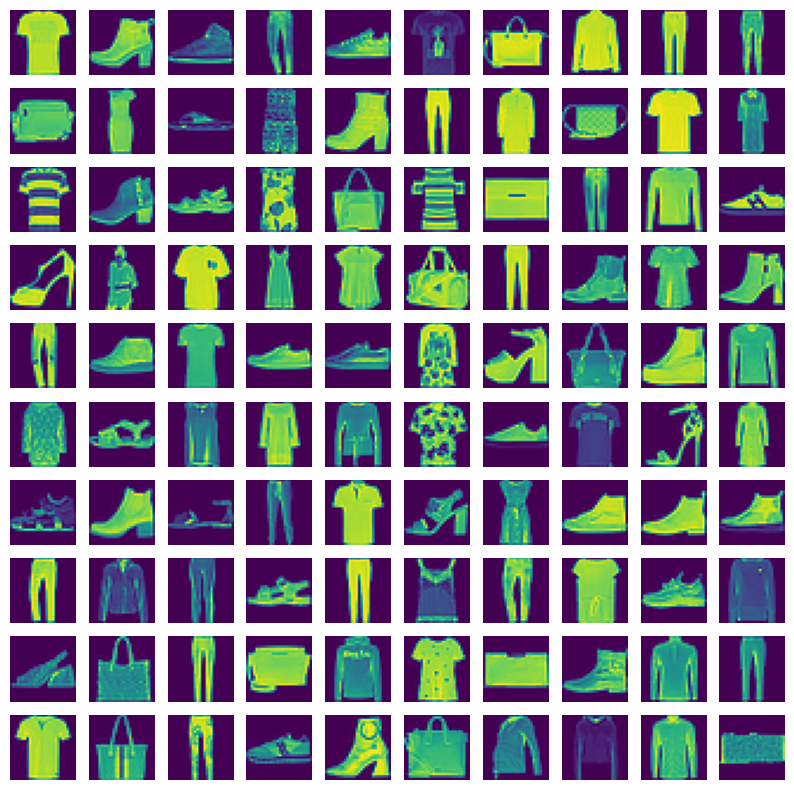

(256, 72, 72, 1)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 72, 72, 1)            3         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 36)             0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              11584     ['patches[0][0]']       

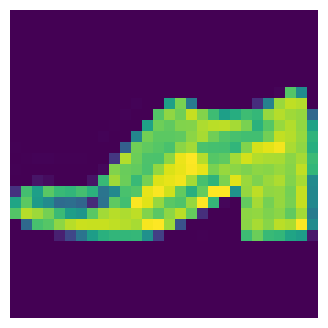

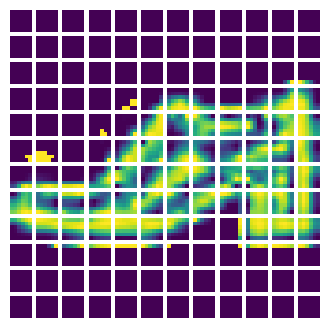

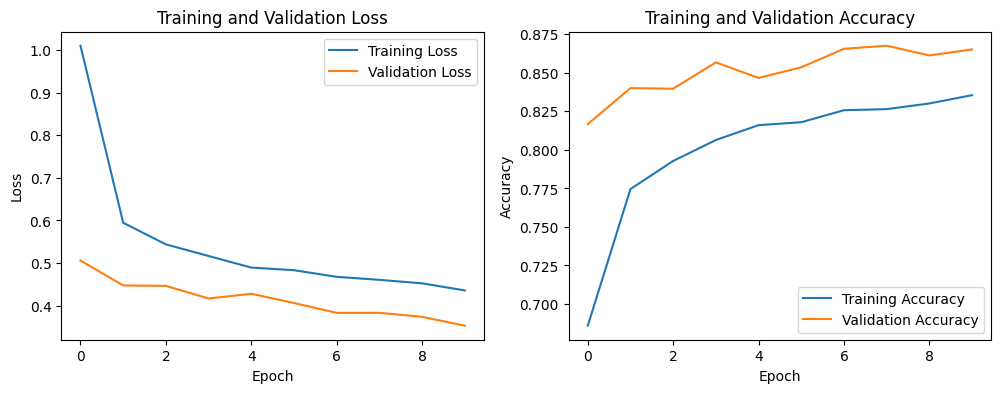

313/313 [==============================] - 66s 207ms/step


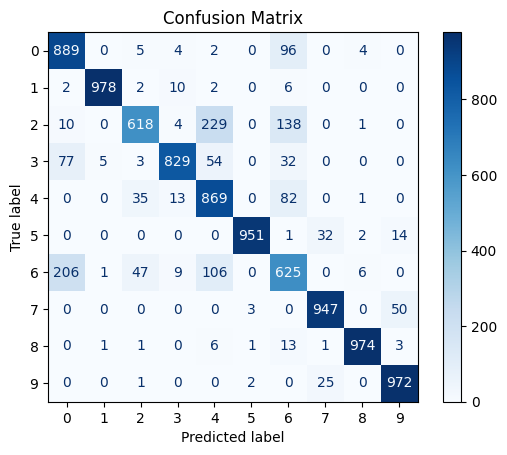

<Axes: >

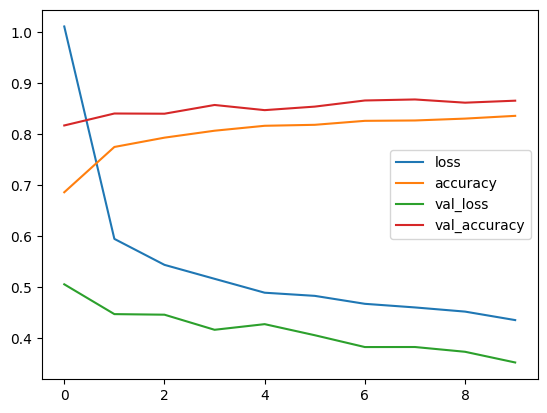

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers


class Config:
    # Origin image size
    input_size = 28
    # Input shape of image
    input_shape = [input_size, input_size, 1]
    # Learning rate of the Model
    learning_rate = 0.001
    # Weight decay rate of the Model
    weight_decay = 0.0001
    # Batch size of the Model
    batch_size = 256
    num_classes = 10
    num_epochs = 10
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]


def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()


train = pd.read_csv("/content/gdrive/MyDrive/REDES/fashion-mnist_train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/REDES/fashion-mnist_test.csv")
train_labels = train.pop("label")
test_labels = test.pop("label")


train = np.array(train).reshape((-1, Config.input_size, Config.input_size, 1))
test = np.array(test).reshape((-1, Config.input_size, Config.input_size, 1))


indices = np.random.choice(train.shape[0], 100)
sample_images(train[indices].squeeze(), 10, 10)


augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x



class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches



plt.figure(figsize=(4, 4))
start_index = np.random.choice(train.shape[0] // 2)
image = train[start_index: start_index + Config.batch_size]
plt.imshow(np.squeeze(image[0]).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor(image), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")



class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads,
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = attention_output + encoder_patches

        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)

        # Skip Connnection 2
        encoder_patches = x3 + x2

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(Config.num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()


optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)



history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
test_predictions = np.argmax(vit_classifier.predict(test), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(Config.num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


pd.DataFrame(history.history).plot()




